<a href="https://colab.research.google.com/github/shrirang20/krishichat-voice-assistance/blob/master/KrishiChat_by_Shrirang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building a RAG 🔥 powered farmer's assistant** 🧑‍🌾 (powered by AI4Bharat)

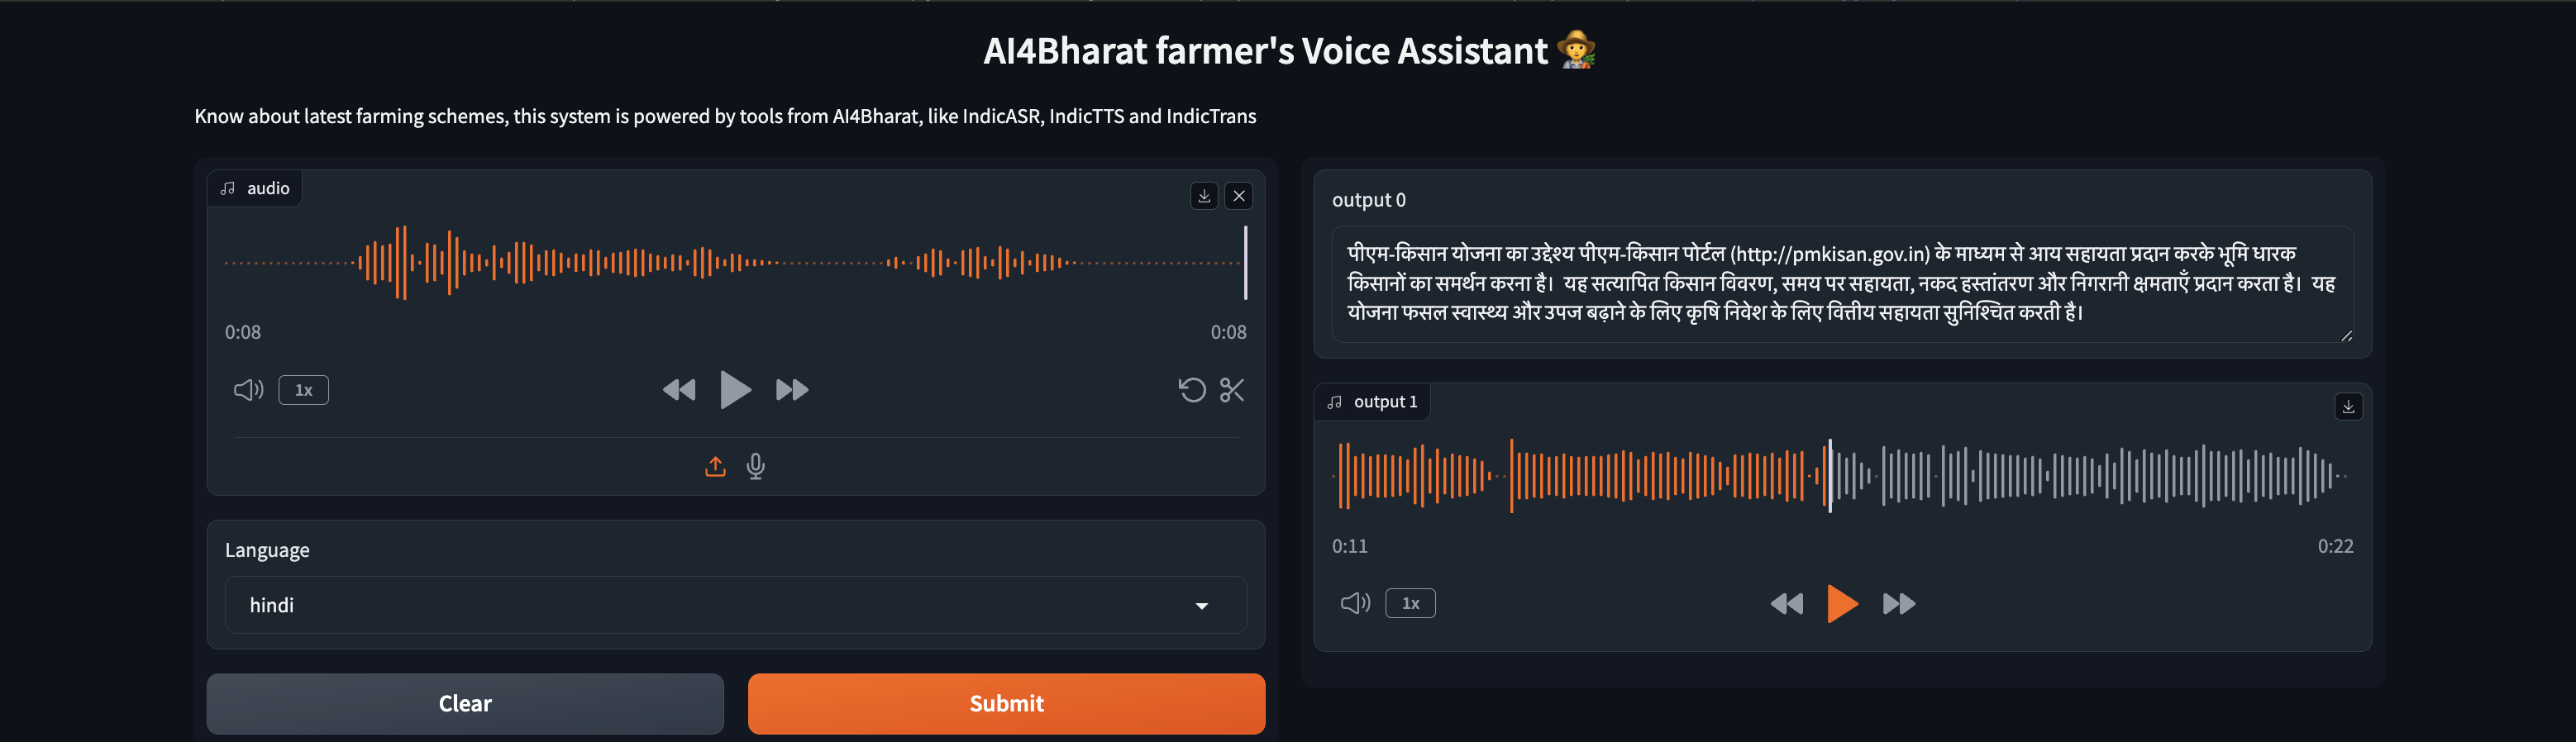

> A user asks "What is PM-Kisan Yojna, also tell me its website" in Hindi

Welcome to the tutorial where we build an **end-to-end voice assistant** to understand how LLMs can be coupled with our own knowledge base.
<br>

We will be using a document containing comprehensive information about a popular Govt Scheme (like PM-kisan yojna) and build a Speech to Speech Chatbot

<br>

In this tutorial we will integrate various models developed by **AI4Bharat**'s team including Translation, Text-to-Speech (TTS) and Automatic Speech Recognition (ASR) models with Google's Gemini-pro model.

<br>
To summarize the entire flow:

1. Transcribing Indic audio to Indic text using *IndicASR*.
2. Translating Indic text to english text using *IndicTrans2*.
3. Loading PDF data into a vector database (*FAISS*) using LangChain.
4. Querying the vector dataabase for the most similar document.
5. Using *Gemini-pro* API to process the retrieved information from vectorDB according to the user's query.
6. Translating english information back to origin language using *IndicTrans2*.
7. Converting the processed information to audio in original language using *IndicTTS*.

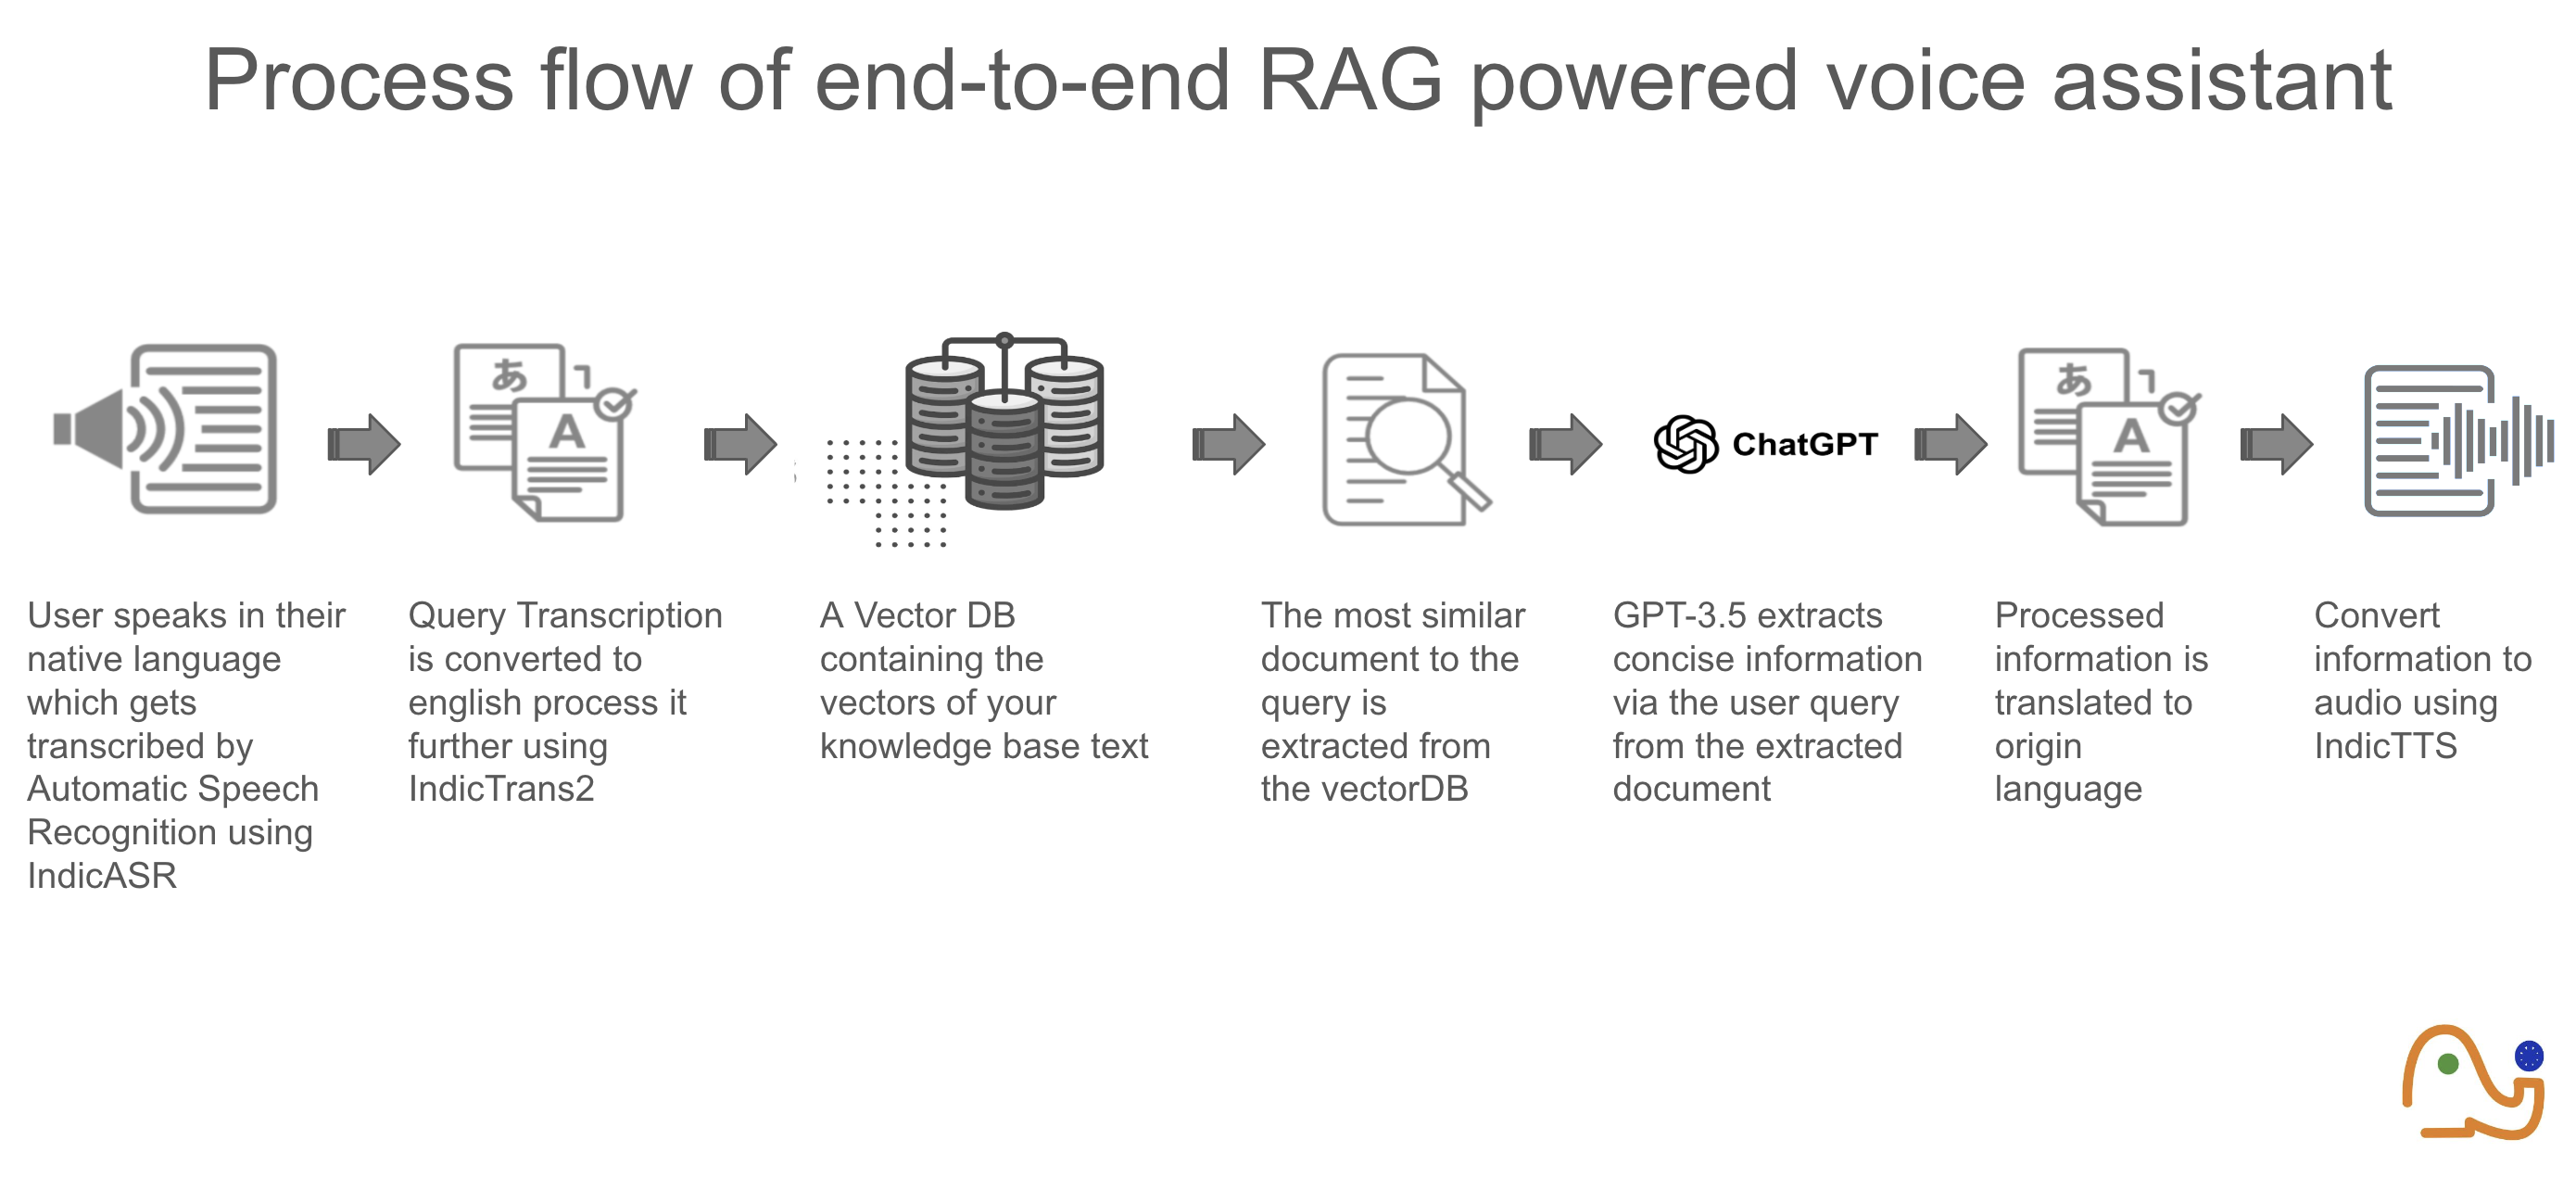

You can run this notebook either on T4 GPU or CPU,
estimated turnaround time:

- T4: ~20 seconds
- CPU: ~2 minutes

## Install dependencies


### General libraries installation


We install:

- *Langchain* for prompt templates, building our Vector DB and generating embeddings from a HuggingFace model


- *FAISS* for vector database

- *PyTorch* for Automatic Speech Recognition

- *PyPDF* for processing PDF data

- *Gradio* for application development

In [ ]:
%%shell

pip install -q langchain_community langchain_huggingface faiss-cpu gradio openai torch torchvision torchaudio youtokentome pypdf accelerate


### Install IndicASR dependencies

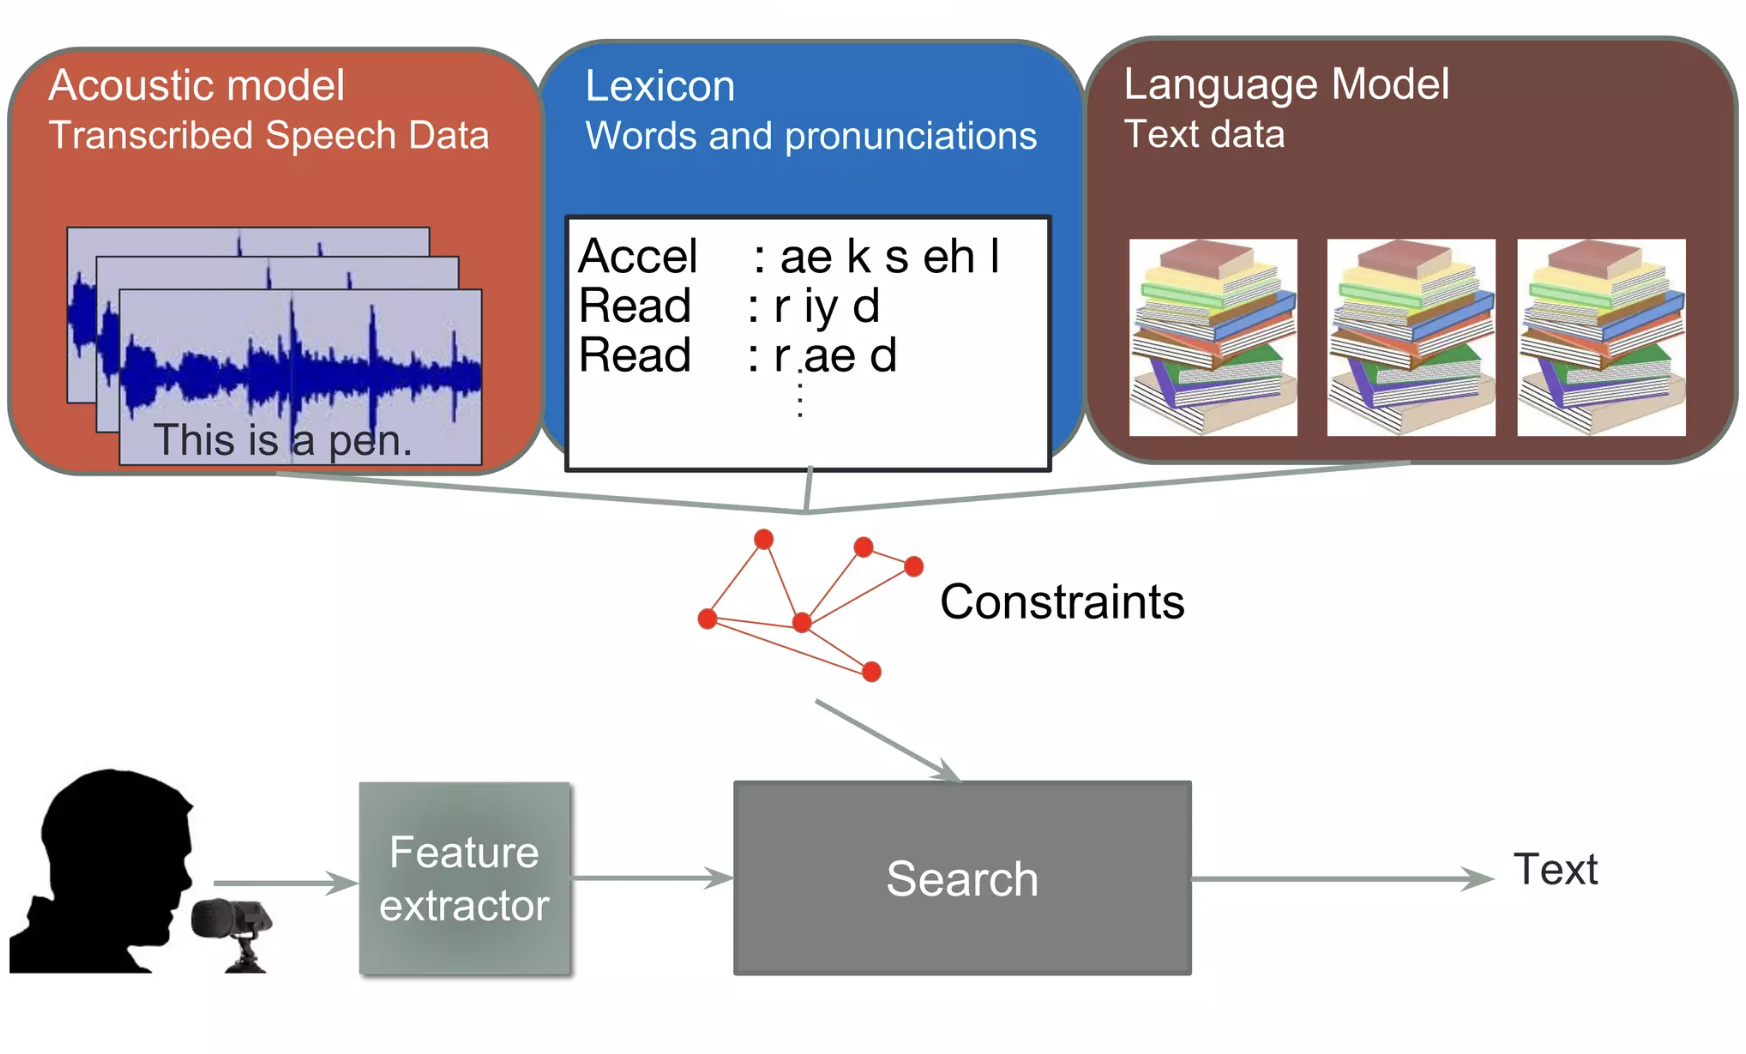



Reference: https://www.slideshare.net/slideshow/build-your-own-asr-engine/117762678#4

Working of an Automatic Speech Recognition (ASR) Model


1. **Audio Input**: The process starts when a microphone captures the sound of your voice and converts it into a digital audio signal. This digital signal is essentially a wave form that represents the variations in air pressure created by your speech.

2. **Preprocessing**: The digital audio signal is cleaned up to remove background noise and other distortions. This step often involves techniques like filtering and normalization to ensure the signal is clear and consistent.

3. **Feature Extraction**: The cleaned audio signal is analyzed to extract key features that are important for recognizing speech. This typically involves breaking the audio into small chunks (called frames) and analyzing these chunks for patterns.

4. **Acoustic Modeling**: The extracted features are then compared against acoustic models, which are statistical representations of different speech sounds (phonemes). These models have been trained on large datasets of recorded speech and corresponding transcriptions, allowing the system to predict which phonemes match the features of the audio signal.

5. **Language Modeling and Decoding**: Finally, the recognized phonemes are put together using a language model that understands the probabilities of different word sequences. This helps in forming coherent and grammatically correct sentences. The system then decodes the best match for the spoken input, converting the series of phonemes into a text output that represents what was said.

We will be using an AI4Bharat version of the NeMo framework released by NVIDIA for using the IndicASR models.

Reference: https://docs.nvidia.com/nemo-framework/user-guide/latest/overview.html

In [ ]:
%%capture
%%shell

# Install the custom version of NeMo by AI4Bharat
wget https://indic-asr-public.objectstore.e2enetworks.net/ai4b_nemo.zip

unzip -q /content/ai4b_nemo.zip && cd NeMo
bash reinstall.sh

cd ..


### Install IndicTrans2 dependencies

Training a Machine Translation Model involves mainly 3 steps:

1. Data Collection: First, we gather a large amount of parallel texts, which are sentences translated from one language to another. For example, a sentence in English and its corresponding translation in Spanish.

2. Learning Language Patterns: The model examines these pairs of sentences to understand the patterns and rules of how words and phrases in one language correspond to those in another language.

3. Training with Pairs: During training, the model learns by looking at many pairs of sentences (source and target). It tries to minimize the difference between the predicted translation and the actual translation. This is done using a technique called backpropagation, where the model adjusts its parameters to improve accuracy.

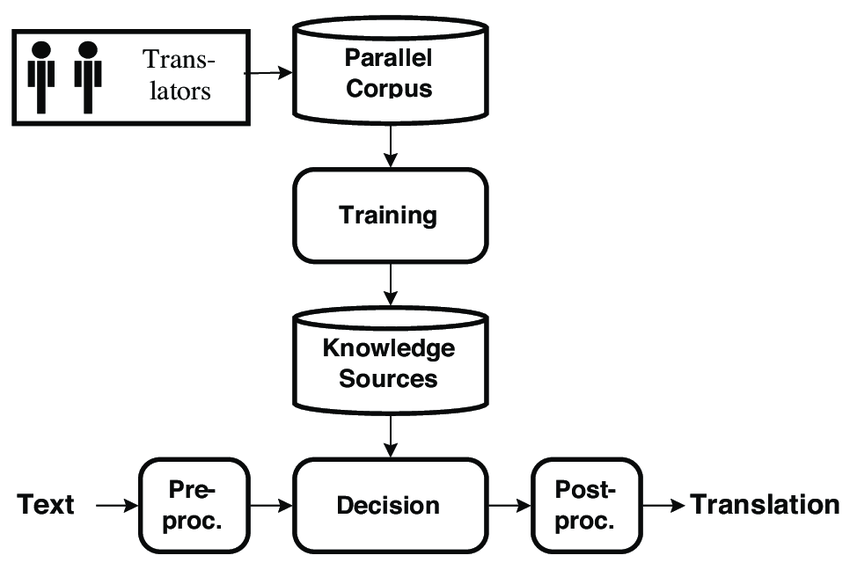

In [ ]:
%%capture
%%shell

git clone -q https://github.com/VarunGumma/IndicTransTokenizer
cd IndicTransTokenizer
pip install -q --editable ./
cd ..


### Install IndicTTS dependencies

Basic components of a TTS (Text-to-Speech) Model:

1. Text Input: The system receives a text input, which can be a sentence, paragraph, or any other form of written language.

2. Text Analysis: This stage breaks down the written text into its basic components. This may involve tasks like splitting sentences into words, identifying parts of speech, and performing other forms of linguistic analysis.

3. Linguistic Features Extraction: Here, the system extracts features from the analyzed text that are relevant to speech production. These features might include things like phoneme identities (the basic units of speech), stress patterns, and intonation.

4. Acoustic Model: This component uses the linguistic features to predict the acoustic features of speech. Acoustic features include things like pitch, volume, and spectral envelope (the frequency distribution of the sound).

5. Vocoder: Finally, the vocoder uses the predicted acoustic features to generate an audio waveform that corresponds to the spoken version of the input text.




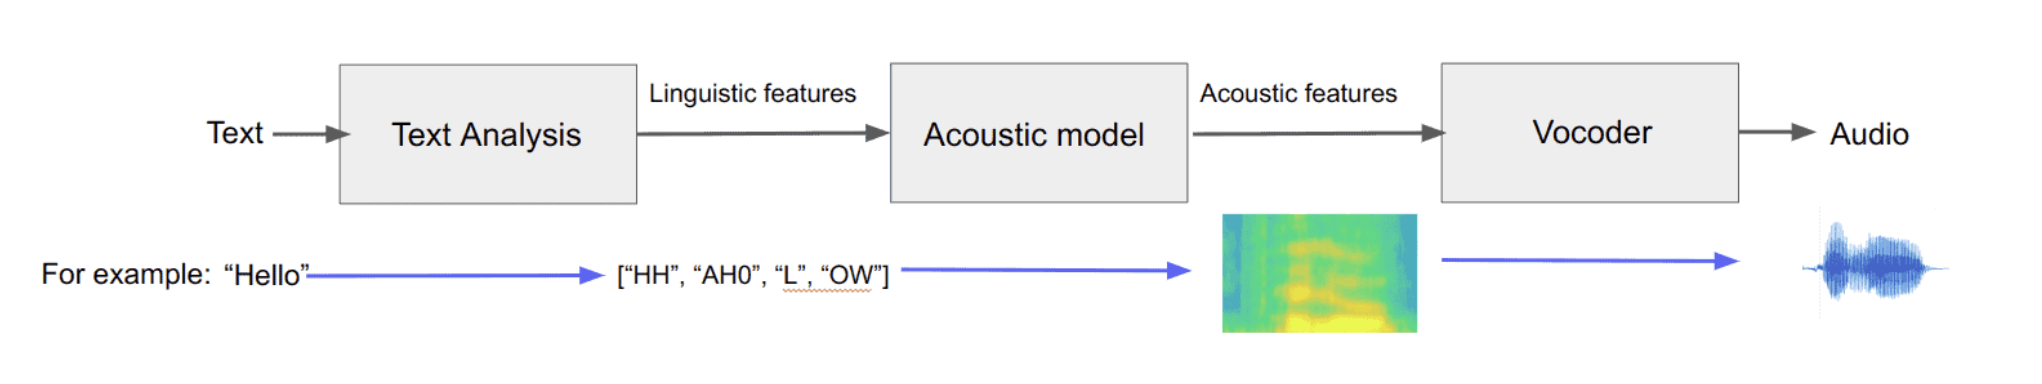

In [ ]:
%%capture
%%shell

apt-get install libsndfile1-dev ffmpeg

git clone https://github.com/gokulkarthik/TTS
cd TTS

pip3 install -e .[all]
pip3 install -r requirements.txt

cd ..


## **Restart session**


In order for some library imports to take effect, we will need to restart the session.

`WARNING: The cells below might lead to import errors if the session is not restarted.`

Runtime --> Restart session

In [ ]:
%%capture

# INFO: If you're unable to import these libraries, just rerun this cell again.

import gradio as gr
from torch import cuda, inference_mode
import nemo.collections.asr as nemo_asr
from IndicTransTokenizer import IndicProcessor
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer


In [ ]:
DEVICE = "cuda" if cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")

Using device: cuda


## Creating a Vector database using FAISS + langchain

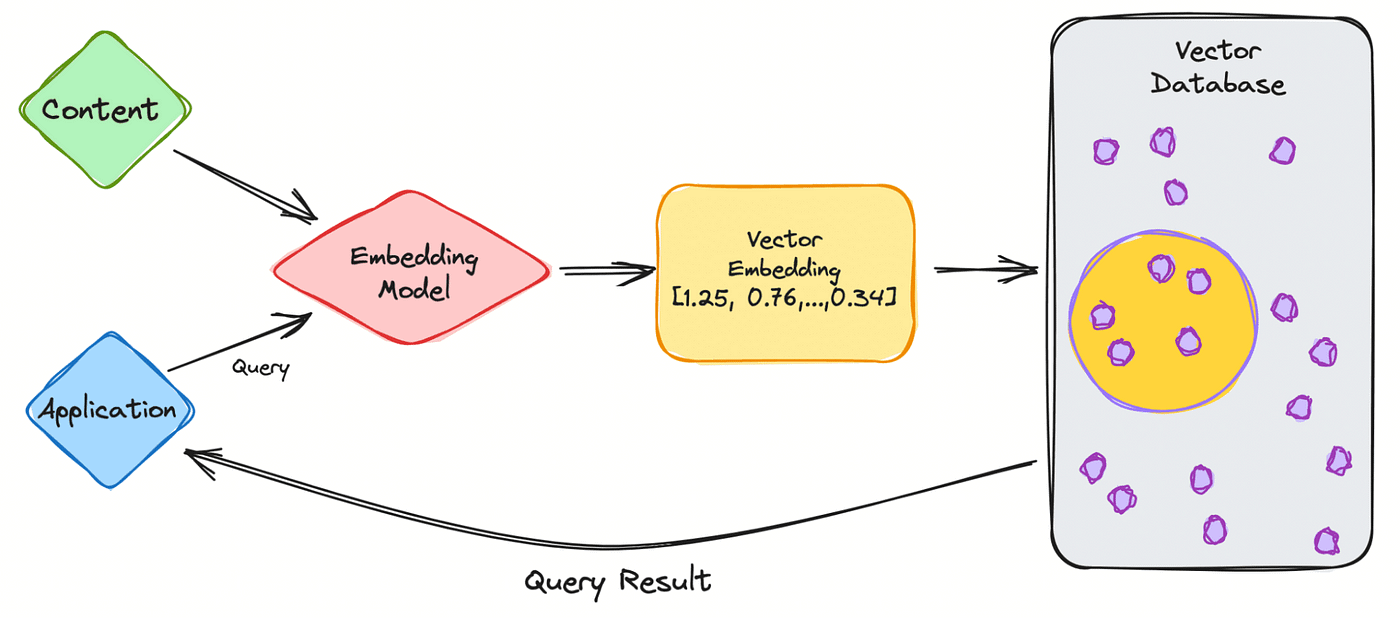

Vector DB in a nutshell:

1. First, we use an embedding model to create vector embeddings for the text.

2. Then the vector embeddings are inserted into the vector database, with a reference to the original text.

3. When the application receives a query, we use the embedding model to create embeddings for the query and use those embeddings to query the database for similar vector embeddings.

4. The most similar embeddings are extracted from the Database.

Here, we will use **FAISS** (Facebook AI Similarity Search) to build a vector DB initialized from a PDF document containing all details of the PM-Kisan Yojna.

- We use Langchain's functions for initializing our vector DB, reading a PDF document directly and for using an embedding model from HuggingFace to embed our PDF text

- Langchain is an Open-source framework designed to integrate LLMs into applications, utilizing the powerful capabiltiies of langchain wrappers.

- FAISS is an open-source vector database by Meta AI, to store embeddings of text at a scale and process queries in miliseconds.


In [ ]:
import os
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import PyPDFLoader

### Load and convert PDF data into vectorDB

In [ ]:
# Download PM-KISAN offical PDF document
# https://www.pmkisan.gov.in/Documents/RevisedPM-KISANOperationalGuidelines(English).pdf

%%shell

gdown 1qXyBzQ_1uNCocPMAl9Z58UlZGteKl5kg

Downloading...
From: https://drive.google.com/uc?id=1qXyBzQ_1uNCocPMAl9Z58UlZGteKl5kg
To: /content/PM-KISANOperationalGuidelines(English).pdf
100% 825k/825k [00:00<00:00, 98.6MB/s]


In [ ]:
pm_kisan_doc = "/content/PM-KISANOperationalGuidelines(English).pdf"

In [ ]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=600,
    chunk_overlap=100
)

loader = PyPDFLoader(pm_kisan_doc)
pages = loader.load_and_split(text_splitter=text_splitter)

pages_chunks = [page.page_content for page in pages]
print(f"Generated {len(pages_chunks)} chunks of {pm_kisan_doc}")

Generated 62 chunks of /content/PM-KISANOperationalGuidelines(English).pdf


In [ ]:
pages_chunks[8]

'not available / does not reside in the village, State / UT Governments may consider \ncertification based on the declaration by other adult member of his / her family. In case \nof incorrect self declaration, beneficiary shall be liable for recovery of transferred \nfinancial benefit and other penal actions as per law. \n5. Methodology for calculation of benefit  \n5.1 The benefit shall be paid to only those farmers’ families whose names are \nentered into the land records. Exception has, however, been made for North-East \nStates and Jharkhand in this regard.'

In [ ]:
!transformers-cli env

2024-07-22 16:16:37.215769: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 16:16:37.215821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 16:16:37.217368: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 16:16:37.224545: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
RuntimeError: module compiled against API ver

In [ ]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

faiss = FAISS.from_texts(pages_chunks, embeddings)

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xe

RuntimeError: Failed to import transformers.integrations.integration_utils because of the following error (look up to see its traceback):
Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
initialization of _pywrap_checkpoint_reader raised unreported exception

### Querying the vectorDB

In [ ]:
# Test query
result = faiss.similarity_search("what are the benefits of PM kisan yojna", k=3)

NameError: name 'faiss' is not defined

In [ ]:
print(result[2].page_content)

NameError: name 'result' is not defined

In [ ]:
# This returns the most relevant doc similar to the query

print(result[0].page_content)

NameError: name 'result' is not defined

## Setup Gemini-pro API

Now the Question comes: Why use Gemini-pro API when open-source models like Llama3, Gemma2 exist ?

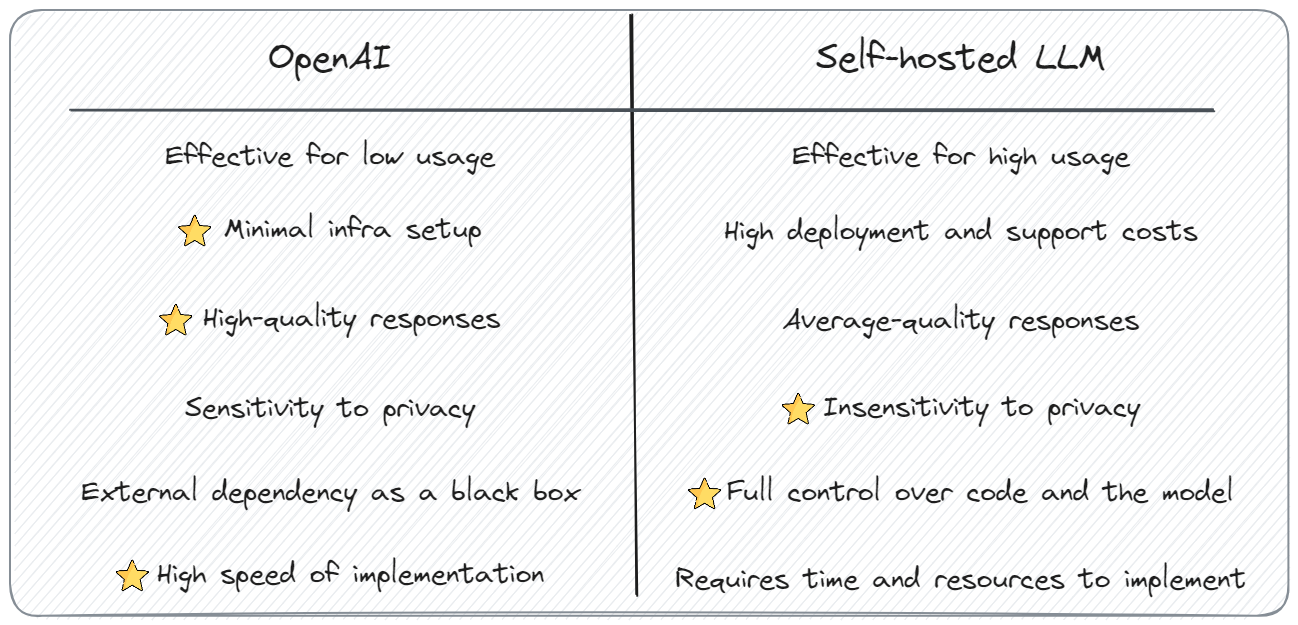

In [ ]:
from google.colab import userdata

os.environ['GEMINI_API_KEY'] = userdata.get('GEMINI_API_KEY')

In [ ]:
import google.generativeai as genai

def get_gemini_output(prompt, temperature=0.6):

    """
    Returns the response from the GPT-3.5-Turbo API

    Args:
        prompt (str): The input prompt to the API
        temperature (int): The temperature of the GPT-3.5-turbo API

    Returns:
        content: The response content from the GPT-3.5-Turbo API.
    """
    genai.configure(api_key= os.environ['GEMINI_API_KEY'])
    model =  genai.GenerativeModel(model_name='gemini-pro')
    answer = model.generate_content(prompt)

    return answer.text

In [ ]:
get_gemini_output("who are you?")

'I am Gemini, a multi-modal AI language model developed by Google. I am designed to understand and generate human language, and to provide information and answer questions to the best of my abilities.'

In [ ]:
get_gemini_output("Tell me about LLM")

'**Large Language Model (LLM)**\n\nAn LLM is an advanced type of artificial intelligence (AI) that has the ability to understand, generate, and translate human language with remarkable accuracy and fluency. They are trained on massive datasets of text and code, enabling them to perform a wide range of language-related tasks.\n\n**Key Characteristics:**\n\n* **Massive Size:** LLMs have billions or trillions of parameters, allowing them to capture complex patterns in language.\n* **Unsupervised Learning:** They are trained without explicit instructions, but rather by identifying patterns in unstructured text data.\n* **Generative Capabilities:** LLMs can generate novel and coherent text, such as articles, stories, and code.\n* **Natural Language Understanding:** They can comprehend the meaning and sentiment of text, including nuances and context.\n* **Multilingual Capabilities:** Many LLMs can work with multiple languages, enabling cross-language translation and comprehension.\n\n**Appli

## Build an end-to-end RAG powered Voice Assistant




In [ ]:
ip = IndicProcessor(inference=True)

In [ ]:
%%capture

en2indic_tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indictrans2-en-indic-dist-200M", trust_remote_code=True)
en2indic_model = AutoModelForSeq2SeqLM.from_pretrained("ai4bharat/indictrans2-en-indic-dist-200M", trust_remote_code=True)


In [ ]:
%%capture

indic2en_tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indictrans2-indic-en-dist-200M", trust_remote_code=True)
indic2en_model = AutoModelForSeq2SeqLM.from_pretrained("ai4bharat/indictrans2-indic-en-dist-200M", trust_remote_code=True)


In [ ]:
model_tokenizer_config = {
    "en2indic": {
        "tokenizer": en2indic_tokenizer,
        "model": en2indic_model,
    },
    "indic2en": {
        "tokenizer": indic2en_tokenizer,
        "model": indic2en_model,
    }
}

IndicTrans2 Supported list of languages along with language codes:

<br>


<table>
<tbody>
  <tr>
    <td>Assamese (asm_Beng)</td>
    <td>Kashmiri (Arabic) (kas_Arab)</td>
    <td>Punjabi (pan_Guru)</td>
  </tr>
  <tr>
    <td>Bengali (ben_Beng)</td>
    <td>Kashmiri (Devanagari) (kas_Deva)</td>
    <td>Sanskrit (san_Deva)</td>
  </tr>
  <tr>
    <td>Bodo (brx_Deva)</td>
    <td>Maithili (mai_Deva)</td>
    <td>Santali (sat_Olck)</td>
  </tr>
  <tr>
    <td>Dogri (doi_Deva)</td>
    <td>Malayalam (mal_Mlym)</td>
    <td>Sindhi (Arabic) (snd_Arab)</td>
  </tr>
  <tr>
    <td>English (eng_Latn)</td>
    <td>Marathi (mar_Deva)</td>
    <td>Sindhi (Devanagari) (snd_Deva)</td>
  </tr>
  <tr>
    <td>Konkani (gom_Deva)</td>
    <td>Manipuri (Bengali) (mni_Beng)</td>
    <td>Tamil (tam_Taml)</td>
  </tr>
  <tr>
    <td>Gujarati (guj_Gujr)</td>
    <td>Manipuri (Meitei) (mni_Mtei)</td>
    <td>Telugu (tel_Telu)</td>
  </tr>
  <tr>
    <td>Hindi (hin_Deva)</td>
    <td>Nepali (npi_Deva)</td>
    <td>Urdu (urd_Arab)</td>
  </tr>
  <tr>
    <td>Kannada (kan_Knda)</td>
    <td>Odia (ory_Orya)</td>
    <td></td>
  </tr>
</tbody>
</table>


In [ ]:
def indic_translate(src_lang: str, tgt_lang: str, sents_to_translate: list):

  """
  Uses IndicTrans2-200M distilled model to translate a list of sentences from a src_lang to tgt_lang

  Args:
      src_lang (str): The input sentences language.
      tgt_lang (str): The language in which we want the sentences to be translated to.
      sents_to_translate (list): The list of input sentences.

  Returns:
      outputs: The list of translated sentencesin tgt_lang.
  """

  lang_map = {
    "punjabi": "pan_Guru",
    "bengali": "ben_Beng",
    "malayalam": "mal_Mlym",
    "marathi": "mar_Deva",
    "tamil": "tam_Taml",
    "gujarati": "guj_Gujr",
    "telugu": "tel_Telu",
    "hindi": "hin_Deva",
    "kannada": "kan_Knda",
    "odia": "ory_Orya",
    "english": "eng_Latn"
    }

  src_lang = lang_map[src_lang]
  tgt_lang = lang_map[tgt_lang]

  if src_lang == "eng_Latn":
    tokenizer = model_tokenizer_config["en2indic"]["tokenizer"]
    model = model_tokenizer_config["en2indic"]["model"]

    print(f"Using en2indic, src_lang: {src_lang}, tgt_lang: {tgt_lang}")

  else:
    tokenizer = model_tokenizer_config["indic2en"]["tokenizer"]
    model = model_tokenizer_config["indic2en"]["model"]

    print(f"Using indic2en, src_lang: {src_lang}, tgt_lang: {tgt_lang}")


  batch = ip.preprocess_batch(sents_to_translate, src_lang=src_lang, tgt_lang=tgt_lang, show_progress_bar=False)
  batch = tokenizer(batch, padding="longest", truncation=True, max_length=256, return_tensors="pt")

  with inference_mode():
      print("Generating...")
      outputs = model.generate(**batch, num_beams=5, num_return_sequences=1, max_length=256)

  with tokenizer.as_target_tokenizer():
      outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True, clean_up_tokenization_spaces=True)

  if tgt_lang != "en_Latn":
    print(f"Postprocessing for {tgt_lang}")
    outputs = ip.postprocess_batch(outputs, lang=tgt_lang)


  return outputs


In [ ]:
def download_ai4b_tts_model(lang: str):

  """
  Download AI4Bharat's TTS models for a given language

  Args:
      lang (str): The language for which we want to download the model.
  """

  lang_map = {
      "odia": "or",
      "hindi": "hi",
      "tamil": "ta",
      "telugu": "te",
      "punjabi": "pa",
      "kannada": "kn",
      "bengali": "bn",
      "marathi": "mr",
      "gujarati": "gu",
      "malayalam": "ml",
  }

  selected_lang = lang_map[lang]

  download_path = f"/content/{selected_lang}.zip"

  if os.path.exists(download_path):
    print(f"IndicTTS Model for {lang} already exists.")

  else:
    !wget https://github.com/AI4Bharat/Indic-TTS/releases/download/v1-checkpoints-release/{selected_lang}.zip
    !mkdir -p /content/models/v1
    !unzip /content/{selected_lang}.zip -d /content/models/v1


In [ ]:
def run_tts(text, tts_lang):

  """
  Convert text to audio using IndicTTS

  Args:
      text (str): The input text, to be converted to audio.
      tts_lang (str): The language in which the text is to be converted to audio.

  """

  lang_map = {
      "odia": "or",
      "hindi": "hi",
      "tamil": "ta",
      "telugu": "te",
      "punjabi": "pa",
      "kannada": "kn",
      "bengali": "bn",
      "marathi": "mr",
      "gujarati": "gu",
      "malayalam": "ml",
  }

  download_ai4b_tts_model(lang=tts_lang)

  tts_lang = lang_map[tts_lang]
  print(f"Lang code: {tts_lang}")


  tts_command = f'python3 -m TTS.bin.synthesize --text "{text}" \
    --model_path /content/models/v1/{tts_lang}/fastpitch/best_model.pth \
    --config_path /content/models/v1/{tts_lang}/fastpitch/config.json \
    --vocoder_path /content/models/v1/{tts_lang}/hifigan/best_model.pth \
    --vocoder_config_path /content/models/v1/{tts_lang}/hifigan/config.json \
    --speakers_file_path /content/models/v1/{tts_lang}/fastpitch/speakers.pth \
    --out_path /content/tts_output.wav \
    --speaker_idx male'

  if DEVICE == "cuda":
    tts_command += " --use_cuda True"
    print(f"Running IndicTTS on GPU")

  else:
    print(f"Running IndicTTS on CPU")

  os.system(tts_command)


In [ ]:
!mkdir /content/asr_models

def download_ai4b_asr_model(lang: str):
  """
  Download AI4Bharat's ASR models for a given language

  Args:
      lang (str): The language for which we want to download the model.
  """

  available_langs = {
      "odia": "or",
      "hindi": "hi",
      "tamil": "ta",
      "telugu": "te",
      "punjabi": "pa",
      "kannada": "kn",
      "bengali": "bn",
      "marathi": "mr",
      "gujarati": "gu",
      "malayalam": "ml",
  }

  download_path = f"/content/asr_models/ai4b_indicConformer_{available_langs[lang]}.nemo"
  print(f"Downloaded ASR model path: {download_path}")

  if os.path.exists(download_path):
      print(f"Model for {lang} already exists.")

  elif lang not in available_langs:
      raise ValueError(f"Invalid language code: {lang}")

  else:
    !wget https://objectstore.e2enetworks.net/indic-asr-public/indicConformer/ai4b_indicConformer_{available_langs[lang]}.nemo -O '/content/asr_models/ai4b_indicConformer_{available_langs[lang]}.nemo'

  return download_path


In [ ]:
# import librosa

# def preprocess_audio(audio_path):
#   audio,sr=librosa.load(audio_path)
#   return audio, sr

def transcribe(audio: str, lang: str):

    """
    Uses IndicASR to transcribe the input audio to text, utilizing a Conformer NeMo model trained of Shrutilipi and IndicSuperb by AI4Bharat

    Args:
        audio (str): The input audio's path.
        lang (str): The language of the input audio.

    Returns:
        transcription: The transcription of input audio.
    """

    # audio,sr = preprocess_audio(audio)

    lang_map = {
      "odia": "or",
      "hindi": "hi",
      "tamil": "ta",
      "telugu": "te",
      "punjabi": "pa",
      "kannada": "kn",
      "bengali": "bn",
      "marathi": "mr",
      "gujarati": "gu",
      "malayalam": "ml",
    }

    download_path = download_ai4b_asr_model(lang=lang)

    asr_model = nemo_asr.models.ASRModel.restore_from(
          download_path, map_location=DEVICE
    )

    transcription = asr_model.transcribe(audio, batch_size=1, language_id=lang_map[lang])[0][0]
    print(f"Transcription: {transcription}")

    return transcription

In [ ]:
def query_vector_db(query):

  """
  Query the FAISS vector DB

  Args:
      query (str): The audio query.

  Returns:
      result (str): Combines top-3 Most similar documents corresponding to the user's query.

  """

  # Combine the top-3 similar documents from the vectorDB
  result = " ".join([result.page_content for result in faiss.similarity_search(query, k=3)])

  return result


In [ ]:
from langchain_core.prompts import PromptTemplate

def process_user_query(user_query, retrieved_doc):

  """
  Uses Gemini-pro to extract the part of the retrieved document from vectorDB which is relevant to user's query

  Args:
      user_query (str): The user's question.
      retrieved_doc (str): The information relevant to user's query.

  Returns:
      processed_doc: TThe extracted information from the given document.
  """

  prompt_template = PromptTemplate.from_template(
    "You are a chatbot , which provides information to user based on their queries, \
    the user asks: {user_query}, The information from the related query is: {retrieved_doc}. \
    Now give the output based on the query and relevant information that i provided, written in a structured, well-formatted and concise way. \
    The length of the output should be no more than 70 words, must be in 5 lines."
  )

  prompt = prompt_template.format(user_query=user_query, retrieved_doc=retrieved_doc)

  processed_doc = get_gemini_output(prompt)
  print(processed_doc)

  return processed_doc


In [ ]:
def process_gradio_input(audio, user_lang):

  """
  End-to-end voice assistant pipeline, no. of inputs and outputs are defined in the Gradio interface

  Args:
      audio (str): The audio path.
      lang (str): The user's input language.

  Returns:
      en_to_indic_doc: The first return value. It is the final answer to user's query.
      audio_outfile_path: The second return value. Path to the generated audio having the final answer.

  """

  # Use IndicASR to transcribe the input audio
  print(f"Transcribing...")
  query_transcription = transcribe(audio, lang=user_lang)

  # Convert the Indic text from transcription to English, so that GPT-3.5 can process it
  print(f"Translating indic to en..")
  indic_to_en = indic_translate(src_lang=user_lang, tgt_lang="english", sents_to_translate=[query_transcription])[0]

  # Query the Vector DB to get the relevant document from the query
  print(f"Querying vector db")
  retrieved_doc = query_vector_db(indic_to_en)

  # Extract relevant information from the retrieved document
  print(f"Processing user query")
  processed_doc = process_user_query(user_query=indic_to_en, retrieved_doc=retrieved_doc)

  # Break the document into chunks for faster batch processing
  print(f"Breaking document into chunks..")
  processed_doc_chunks = processed_doc.strip().split(". ")
  processed_doc_chunks = [f"{chunk}." for chunk in processed_doc_chunks if chunk != ""]

  # Translate the the extracted information back to Indic language
  print(f"Translating en to indic..")
  en_to_indic_chunks = indic_translate(src_lang="english", tgt_lang=user_lang, sents_to_translate=processed_doc_chunks)
  en_to_indic_doc = " ".join(en_to_indic_chunks)
  print(f"en_to_indic_doc: {en_to_indic_doc}")

  # Run IndicTTS to generate audio
  print(f"Running TTS to generate audio..")
  run_tts(text=en_to_indic_doc, tts_lang=user_lang)
  print("Finished running TTS")

  audio_outfile_path = "/content/tts_output.wav"


  return en_to_indic_doc, audio_outfile_path


In [ ]:
def launch_gradio_app(show_log=False):

  """
  Launches the Gradio app for the voice assistant pipeline

  Args:
      show_log (bool): Whether to show the pipeline logs or not.

  """

  languages = ["hindi", "odia", "tamil", "telugu", "punjabi", "kannada", "bengali", "marathi", "gujarati", "malayalam"]

  iface = gr.Interface(
      fn=process_gradio_input,
      inputs=[
          gr.Audio(sources=['upload', 'microphone'], type="filepath", show_download_button=True),  # Input audio
          gr.Dropdown(languages, label="Language", value="hindi"),  # Language selection
      ],
      outputs=["text", "audio"],
      allow_flagging="never",
      title="Krishi Chat with Voice Assistant Powered by AI4Bharat and NVIDIA Nemo🧑‍🌾",
      description="Know about latest farming schemes, this system is powered by tools from AI4Bharat, like IndicASR, IndicTTS and IndicTrans",
  )

  iface.launch(debug=show_log)


In [ ]:
launch_gradio_app(show_log=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://fe462c41f41aa29506.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://fe462c41f41aa29506.gradio.live
